In [1]:
#https://ieeexplore.ieee.org/document/10549889

In [2]:
!pip install openpyxl ssqueezepy

Defaulting to user installation because normal site-packages is not writeable


In [3]:
# !pip install --upgrade tensorflow

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential
from tensorflow.keras.applications import ResNet50
from ssqueezepy import cwt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt
import pywt
import matplotlib.pyplot as plt

2024-12-18 09:36:19.196704: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-18 09:36:19.196807: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-18 09:36:19.196840: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-18 09:36:19.205875: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
import keras.models
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [6]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [7]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [8]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [9]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [10]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [11]:
# from sklearn.preprocessing import StandardScaler

# def scale_data(trainX, testX):
#  # remove overlap
#  cut = int(trainX.shape[1] / 2)
#  longX = trainX[:, -cut:, :]
#  # flatten windows
#  longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
#  # flatten train and test
#  flatTrainX = trainX.reshape((trainX.shape[0] * trainX.shape[1], trainX.shape[2]))
#  flatTestX = testX.reshape((testX.shape[0] * testX.shape[1], testX.shape[2]))

#  s = StandardScaler()
#  # fit on training data
#  s.fit(longX)
#  # apply to training and test data
#  longX = s.transform(longX)
#  flatTrainX = s.transform(flatTrainX)
#  flatTestX = s.transform(flatTestX)
#  # reshape
#  flatTrainX = flatTrainX.reshape((trainX.shape))
#  flatTestX = flatTestX.reshape((testX.shape))
#  return flatTrainX, flatTestX

In [12]:
# trainX, testX = scale_data(trainX, testX)

In [13]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [14]:
import random

dynamic_1 = np.where(trainy == 0)[0]
dynamic_2 = np.where(trainy == 1)[0]
dynamic_3 = np.where(trainy == 2)[0]
dynamic = np.concatenate([dynamic_1, dynamic_2, dynamic_3])
dynamic_list = dynamic.tolist()

# Shuffle dynamic data index
r = random.random()
random.shuffle(dynamic_list, lambda: r)

dynamic = np.array(dynamic)

trainX = X_train_all[dynamic]
trainy = y_train_all[dynamic]

/tmp/ipykernel_1603/2880528613.py:11: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(dynamic_list, lambda: r)


In [15]:
dynamic_1 = np.where(testy == 0)[0]
dynamic_2 = np.where(testy == 1)[0]
dynamic_3 = np.where(testy == 2)[0]
dynamic = np.concatenate([dynamic_1, dynamic_2, dynamic_3])
dynamic_list = dynamic.tolist()

r = random.random()
random.shuffle(dynamic_list, lambda: r)

dynamic = np.array(dynamic_list)

testX = X_test_all[dynamic]
testy = y_test_all[dynamic]

/tmp/ipykernel_1603/3566874998.py:8: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(dynamic_list, lambda: r)


In [16]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]]


In [17]:
trainy_one_hot = to_categorical(trainy)
testy_one_hot = to_categorical(testy)

In [18]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (3285, 128, 9)
Y train shape:  (3285, 1)
Y train One hot shape:  (3285, 3)
X test shape:  (1387, 128, 9)
Y test shape:  (1387, 1)
Y test One hot shape:  (1387, 3)


In [19]:
n_classes = 3

In [20]:
print(trainX.shape)
print(trainy_one_hot.shape)

(3285, 128, 9)
(3285, 3)


In [21]:
X_train_lstm = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
X_test_lstm = np.reshape(testX, (testX.shape[0], testX.shape[1], trainX.shape[2]))
y_train_lstm = trainy_one_hot
y_test_lstm = testy_one_hot

In [22]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy_one_hot.shape[1]

In [23]:
import numpy as np
import tensorflow as tf
from scipy.signal import cwt, morlet

def CWT_transform_multichannel(data):
    """
    Apply CWT transform to each channel of the data.
    :param data: numpy array of shape (samples, timesteps, features)
    :return: numpy array of shape (samples, 128, 128, features)
    """
    samples, timesteps, channels = data.shape
    widths = np.arange(1, 129)  # Define widths for CWT (example: 1 to 128 scales)
    images = []

    for sample_idx in range(samples):
        transformed_channels = []
        for channel_idx in range(channels):
            signal = data[sample_idx, :, channel_idx]  # Extract one signal (timesteps,)
            # Apply Continuous Wavelet Transform (CWT)
            Wx = cwt(signal, morlet, widths)  # Add widths as the third argument
            Wx = np.abs(Wx)
            Wx = (Wx - Wx.min()) / (Wx.max() - Wx.min())  # Normalize
            # Resize CWT output to (128, 128)
            Wx_resized = tf.image.resize(Wx[..., np.newaxis], [128, 128]).numpy()
            transformed_channels.append(Wx_resized)  # Shape (128, 128, 1)

        # Stack all channels to form a multi-channel image
        transformed_image = np.concatenate(transformed_channels, axis=-1)  # Shape (128, 128, channels)
        images.append(transformed_image)

    images = np.array(images)
    print(f"Shape of transformed data: {images.shape}")
    return images


# Perform CWT transform
X_train_cwt = CWT_transform_multichannel(trainX)
X_test_cwt = CWT_transform_multichannel(testX)

print(f"Final CNN Data Shapes:\nX_train_cwt: {X_train_cwt.shape}, X_test_cwt: {X_test_cwt.shape}")


2024-12-18 09:36:26.976611: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38698 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:c8:00.0, compute capability: 8.0
2024-12-18 09:36:26.978711: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38698 MB memory:  -> device: 1, name: CUDA GPU, pci bus id: 0000:cc:00.0, compute capability: 8.0


Shape of transformed data: (3285, 128, 128, 9)
Shape of transformed data: (1387, 128, 128, 9)
Final CNN Data Shapes:
X_train_cwt: (3285, 128, 128, 9), X_test_cwt: (1387, 128, 128, 9)


In [24]:
# Slice CNN data to match LSTM samples
X_train_cwt = X_train_cwt[:X_train_lstm.shape[0]]
X_test_cwt = X_test_cwt[:X_test_lstm.shape[0]]

# Debug final shapes
print("After Slicing:")
print(f"X_train_cwt shape: {X_train_cwt.shape}, X_train_lstm shape: {X_train_lstm.shape}")
print(f"y_train_lstm shape: {y_train_lstm.shape}")

After Slicing:
X_train_cwt shape: (3285, 128, 128, 9), X_train_lstm shape: (3285, 128, 9)
y_train_lstm shape: (3285, 3)


In [25]:
# Transformer Encoder Layer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Network
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [26]:
# Transformer Encoder Layer
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Network
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [27]:
# Transformer Branch 수정
def build_transformer_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0.3,
    mlp_dropout=0.3,
):
    # 입력 이름을 명시적으로 설정
    inputs = keras.Input(shape=input_shape, name="Transformer_Input")
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    return inputs, x

In [28]:
# Combined CNN + Transformer Model for Classification
def build_combined_model_classification(
    cnn_input_shape,
    transformer_input_shape,
    transformer_params,
    mlp_units,
    num_classes=3,  # For classification task
    dropout=0.25,
):
    # CNN Branch
    cnn_inputs = keras.Input(shape=cnn_input_shape, name="CNN_Input")
    x = layers.Conv2D(32, (3, 3), activation="relu")(cnn_inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation="relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation="relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    cnn_outputs = layers.Dense(128, activation="relu")(x)

    # Transformer Branch
    transformer_inputs, transformer_outputs = build_transformer_model(
        transformer_input_shape, **transformer_params, mlp_units=mlp_units
    )

    # Combine CNN and Transformer
    combined = layers.concatenate([cnn_outputs, transformer_outputs])
    x = layers.Dense(128, activation="relu")(combined)
    x = layers.Dropout(dropout)(x)
    
    # Output Layer for Classification
    outputs = layers.Dense(num_classes, activation="softmax", name="Classification_Output")(x)

    # Build and compile model
    model = Model(inputs=[cnn_inputs, transformer_inputs], outputs=outputs)
    return model


In [29]:
# Define input shapes
cnn_input_shape = (128, 128, 9)  # CNN 입력 형태
transformer_input_shape = (128, 9)  # Transformer 입력 형태

# Transformer 설정
transformer_params = {
    "head_size": 64,
    "num_heads": 4,
    "ff_dim": 128,
    "num_transformer_blocks": 2,
    "dropout": 0.3
}

# 모델 빌드
model = build_combined_model_classification(
    cnn_input_shape=cnn_input_shape,
    transformer_input_shape=transformer_input_shape,
    transformer_params=transformer_params,
    mlp_units=[128, 64],  # MLP 레이어 유닛 설정
    num_classes=3,        # 클래스 수
    dropout=0.25          # 드롭아웃 비율
)

# 모델 컴파일
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# 모델 구조 확인
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Transformer_Input (InputLa  [(None, 128, 9)]             0         []                            
 yer)                                                                                             
                                                                                                  
 multi_head_attention (Mult  (None, 128, 9)               9993      ['Transformer_Input[0][0]',   
 iHeadAttention)                                                     'Transformer_Input[0][0]']   
                                                                                                  
 dropout (Dropout)           (None, 128, 9)               0         ['multi_head_attention[0][0]']
                                                                                              

                                                                                                  
 flatten (Flatten)           (None, 12544)                0         ['max_pooling2d_2[0][0]']     
                                                                                                  
 dense_2 (Dense)             (None, 64)                   8256      ['dropout_4[0][0]']           
                                                                                                  
 dense (Dense)               (None, 128)                  1605760   ['flatten[0][0]']             
                                                                                                  
 dropout_5 (Dropout)         (None, 64)                   0         ['dense_2[0][0]']             
                                                                                                  
 concatenate (Concatenate)   (None, 192)                  0         ['dense[0][0]',               
          

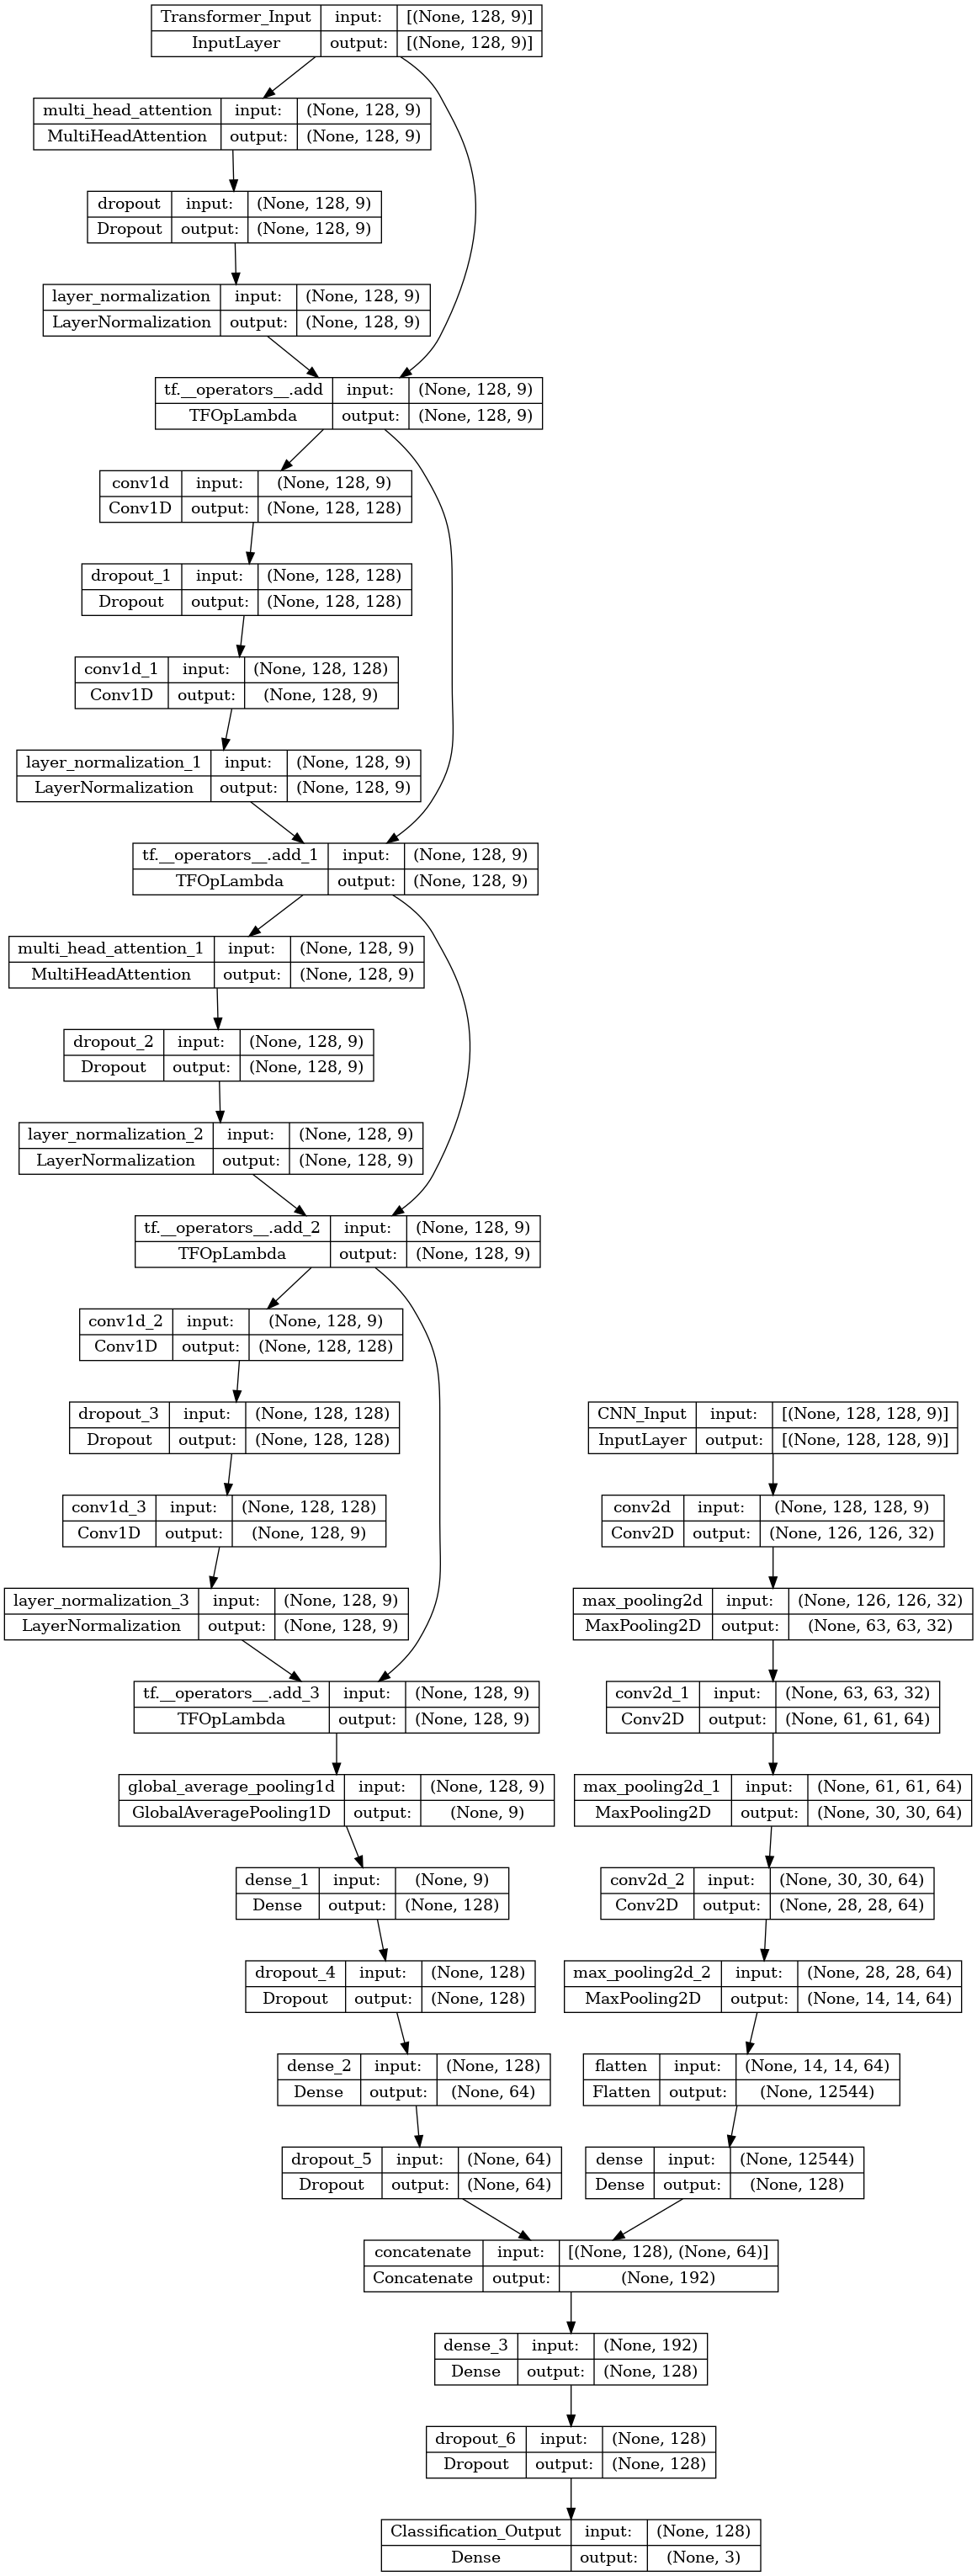

In [30]:
from tensorflow.keras.utils import plot_model

# 모델 시각화
plot_model(
    model,                   # 학습에 사용된 모델
    to_file="model_plot.png",  # 저장할 파일 이름
    show_shapes=True,         # 각 레이어의 출력 텐서 모양 표시
    show_layer_names=True,    # 레이어 이름 표시
    expand_nested=True,       # 중첩된 모델 (서브모델) 시각화
    dpi=96                    # 해상도 설정
)

In [31]:
print("X_train_lstm shape:", X_train_lstm.shape)
print("X_train_cwt shape:", X_train_cwt.shape)
print("y_train_lstm shape:", y_train_lstm.shape)

X_train_lstm shape: (3285, 128, 9)
X_train_cwt shape: (3285, 128, 128, 9)
y_train_lstm shape: (3285, 3)


In [32]:
# import tensorflow as tf

# X_train_lstm = tf.convert_to_tensor(X_train_lstm, dtype=tf.float32)
# X_train_cwt = tf.convert_to_tensor(X_train_cwt, dtype=tf.float32)
# y_train_lstm = tf.convert_to_tensor(y_train_lstm, dtype=tf.float32)

In [33]:
# EarlyStopping 콜백 설정
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True
)

# 모델 학습
history = model.fit(
    {"CNN_Input": X_train_cwt, "Transformer_Input": X_train_lstm},  # 입력 데이터
    {"Classification_Output": y_train_lstm},  # 출력 데이터
    validation_split=0.2,
    epochs=500,
    batch_size=32,
    callbacks=[early_stopping])

Epoch 1/500


2024-12-18 09:43:47.054670: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-12-18 09:43:48.621738: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f7f00003c00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-18 09:43:48.621770: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): CUDA GPU, Compute Capability 8.0
2024-12-18 09:43:48.621778: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): CUDA GPU, Compute Capability 8.0
2024-12-18 09:43:48.627012: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-18 09:43:48.707336: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


83/83 [==============================] - 11s 34ms/step - loss: 0.3989 - accuracy: 0.8489 - val_loss: 1.1374 - val_accuracy: 0.5008
Epoch 2/500
83/83 [==============================] - 1s 16ms/step - loss: 0.1080 - accuracy: 0.9581 - val_loss: 0.4111 - val_accuracy: 0.8737
Epoch 3/500
83/83 [==============================] - 1s 16ms/step - loss: 0.0480 - accuracy: 0.9814 - val_loss: 1.4356 - val_accuracy: 0.6697
Epoch 4/500
83/83 [==============================] - 1s 16ms/step - loss: 0.0932 - accuracy: 0.9703 - val_loss: 0.3456 - val_accuracy: 0.8752
Epoch 5/500
83/83 [==============================] - 1s 15ms/step - loss: 0.0184 - accuracy: 0.9928 - val_loss: 0.5391 - val_accuracy: 0.8371
Epoch 6/500
83/83 [==============================] - 1s 16ms/step - loss: 0.0069 - accuracy: 0.9977 - val_loss: 0.2358 - val_accuracy: 0.9406
Epoch 7/500
83/83 [==============================] - 1s 15ms/step - loss: 0.0029 - accuracy: 0.9996 - val_loss: 0.2790 - val_accuracy: 0.9239
Epoch 8/500
83/83

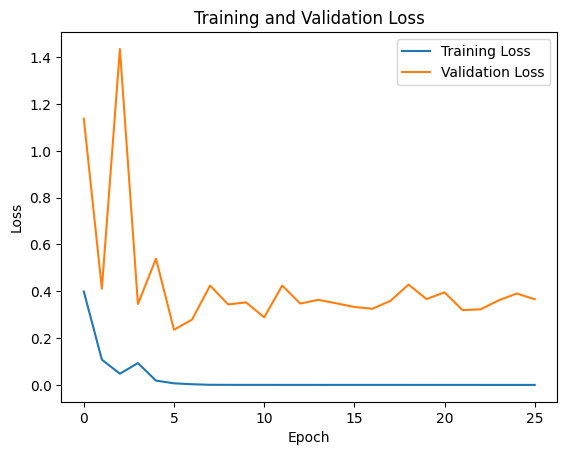

In [34]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

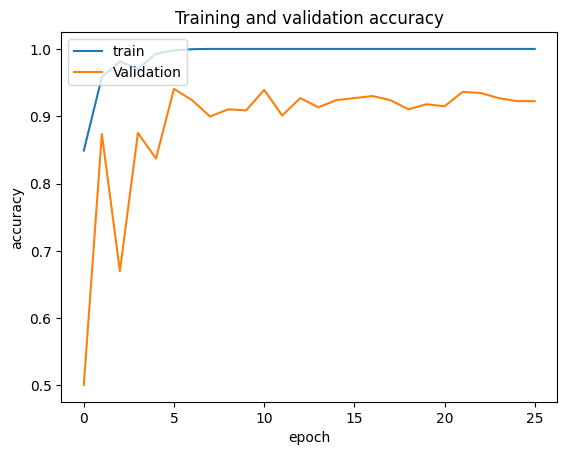

In [35]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

44/44 [==============================] - 1s 6ms/step


(<Figure size 700x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

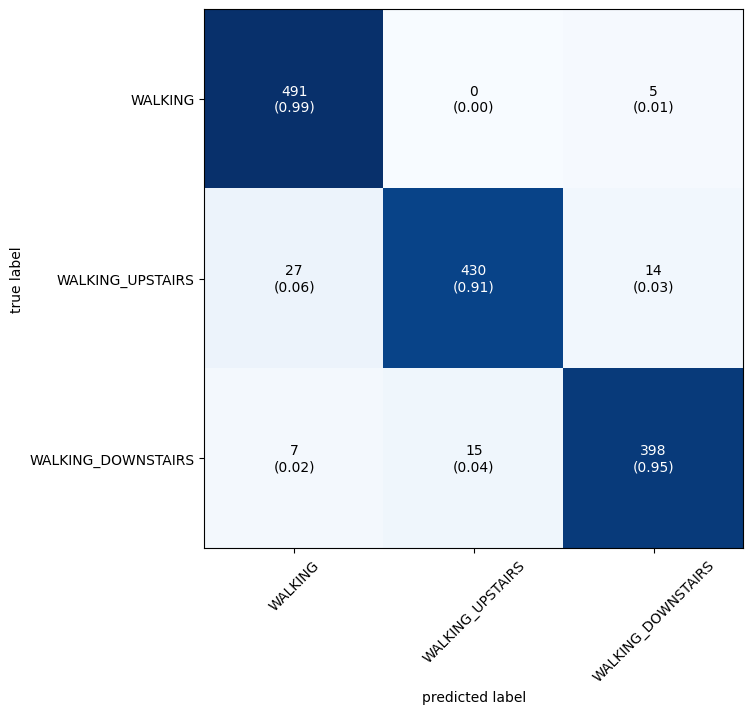

In [36]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy = model.predict({"CNN_Input": X_test_cwt, "Transformer_Input": X_test_lstm})
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS']
cm=confusion_matrix(testy,predy)
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7,7))

In [37]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))

[[491   0   5]
 [ 27 430  14]
 [  7  15 398]]
0.9509733237202596
0.9507466706764852
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       496
           1       0.97      0.91      0.94       471
           2       0.95      0.95      0.95       420

    accuracy                           0.95      1387
   macro avg       0.95      0.95      0.95      1387
weighted avg       0.95      0.95      0.95      1387

